### Training Gated MultiModal Unit

###### load pretrained BERT model

In [1]:
!wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
!tar xf mmimdb-256.tar.gz -C ./data/mmimdb-256/

--2020-12-03 03:05:12--  http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643479473 (614M) [application/x-gzip]
Saving to: ‘mmimdb-256.tar.gz’

mmimdb-256.tar.gz   100%[===================>] 613.67M   111MB/s    in 5.6s    

2020-12-03 03:05:19 (109 MB/s) - ‘mmimdb-256.tar.gz’ saved [643479473/643479473]



In [1]:
!pip install livelossplot --quiet
!pip -q install transformers

In [2]:
import torch, os, json
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

### Load Pretrained Bert Model

In [3]:
text_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = 27,  output_attentions = False, 
    output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
text_model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [5]:
text_model.load_state_dict(torch.load('best_model_bert.pth'))

<All keys matched successfully>

### Load Pretrained Resnet 

In [6]:

from torchvision import models

image_model = models.resnet18(pretrained=True) 
image_model.cuda()
num_ftrs = image_model.fc.in_features
image_model.fc = nn.Linear(num_ftrs, 27)

In [7]:
image_model.load_state_dict(torch.load('best_img_model.pth'))

<All keys matched successfully>

Equations governing GMU are as follows: <br>
$h_{v} = tanh(W_{v} \cdot x_{})$ <br>
$h_{t} = tanh(W_{t} \cdot x_{t})$ <br>
$z = \sigma(W_{z} \cdot[x_{v} \cdot x_{t}])$ <br>
$h = z \ast h_{v} + (1 - z) \ast h_{t}$ <br>
$\Theta = \{W_{v}, W_{t}, W_{z}\}$ <br>


In [8]:


# used to find h_v and h_t
class LinearClassifier(nn.Module):  
  def __init__(self, encoding_size):
    super(LinearClassifier, self).__init__()
    self.linear = nn.Linear(encoding_size, encoding_size)

  def forward(self, x):
    x = self.linear(x)
    x = torch.tanh(x)
    return x


In [9]:
class LinearCombine(nn.Module):
  def __init__(self, encoding_size):
    super().__init__()
    self.linear = nn.Linear(encoding_size, 27) # 27 is the number of genres

    self.sigmoid = nn.Sigmoid()

  def forward(self, x, y):
    x = self.linear(torch.cat((x, y), dim=1))
    x = self.sigmoid(x)
    return x


In [10]:
class Gated_MultiModal_Unit():

  def __init__(self, img_model, text_model):
    super().__init__()
    self.bert_model = text_model
    self.resnet_model = img_model
    self.hv_gate = LinearClassifier(27) # num of categories
    self.ht_gate = LinearClassifier(27) # num of categories
    self.z_gate = LinearCombine(54) # 2* num of categories, for data fusion



  def forward(self, mode,imgs, texts, text_masks, labels):
    if (mode == 'train'):
      self.hv_gate.train()
      self.ht_gate.train()
      self.z_gate.train()

    else:
      self.hv_gate.eval()
      self.ht_gate.eval()
      self.z_gate.eval()

    self.resnet_model.eval()
    self.bert_model.eval()
    self.resnet_model.cuda()
    self.bert_model.cuda()
    img_pred = self.resnet_model(imgs)
    text_pred = self.bert_model(texts, text_masks).logits

    
    self.hv_gate.cuda()
    self.ht_gate.cuda()
    self.z_gate.cuda()


    h_v = self.hv_gate(img_pred)
    h_t = self.ht_gate(text_pred)

    z = self.z_gate(img_pred, text_pred)

    h = (torch.mul(z, h_v)) + (torch.mul((1-z), h_t))

    predictions = h
    return predictions




In [11]:
class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'data/mmimdb-256/dataset-resized-256max', split = 'dev',
                 image_transform = None):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')
        print(self.metadata)
        # Pre-tokenizing all sentences.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            self.tokenized_plots.append(encoded_text)
        print(' finished')
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        text = self.tokenized_plots[index]['input_ids'][0]
        text_mask = self.tokenized_plots[index]['attention_mask'][0]
        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        return image, text, text_mask, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))

Loading data/mmimdb-256/dataset-resized-256max/dev/metadata ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 finished
Data size: 2608 samples


In [12]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 4)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

Loading data/mmimdb-256/dataset-resized-256max/train/metadata ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 finished
Loading data/mmimdb-256/dataset-resized-256max/dev/metadata ... finished


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 finished


In [13]:
gmu = Gated_MultiModal_Unit(image_model, text_model)

In [14]:
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

def f_score(predicted, labels):
    #print(predicted)
    #print(predicted.data.sigmoid())
    pred_vals = predicted.data.sigmoid() > 0.5
    #print(pred_vals)
    #print(labels)
    true_positive = ((pred_vals==1) & (pred_vals == labels)).sum(dim = 1)
    false_positive = ((pred_vals==1) & (pred_vals != labels)).sum(dim = 1)
    false_negative = ((pred_vals==0) & (pred_vals != labels)).sum(dim = 1)
    f_score = true_positive/(true_positive+(false_positive+false_negative)/2)
    return f_score

In [20]:
from transformers import AdamW  # optimizer that comes with this library.
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 4

total_steps = len(train_loader) * num_epochs
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')
best_accuracy = 0

# Training Loop. 
def train_gmu(model, optimizer, criterion,num_epochs=4):
  best_accuracy = 0
  liveloss = PlotLosses(); current_step = 0
  for epoch in range(0, num_epochs):
      cumulative_accuracy = 0
      cumulative_fscore = 0
      cumulative_loss = 0
      num_samples = 0
      logs = {}
      # model.train()
      # training loop
      for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
          optimizer.zero_grad()
          # Move to GPU.
          if(torch.cuda.is_available()):
            imgs = imgs.cuda()
            texts = texts.cuda()
            text_masks = text_masks.cuda()
            labels = labels.cuda()

          # Compute predictions.
          predicted = model.forward('train', imgs, texts, text_masks, labels)
          loss = criterion(predicted, labels)
          loss.mean().backward()
          optimizer.step() 
          cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
          cumulative_loss += loss.data.sum().item()
          f_s = f_score(predicted, labels)
          cumulative_fscore +=f_s.sum().item()
          num_samples += texts.size(0)
          # print("Multimodal Accuracy: ", cumulative_accuracy/num_samples)
          # print("Multimodal Fscore: ", cumulative_fscore/num_samples)

          if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            logs['f_score'] = cumulative_fscore/num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1

      # validation loop
      cumulative_accuracy = 0
      cumulative_fscore = 0
      cumulative_loss = 0
      num_samples = 0
      for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
          optimizer.zero_grad()
          # Move to GPU.
          if(torch.cuda.is_available()):
            imgs = imgs.cuda()
            texts = texts.cuda()
            text_masks = text_masks.cuda()
            labels = labels.cuda()

          # Compute predictions.
          predicted = model.forward('validation', imgs, texts, text_masks, labels)
          loss = criterion(predicted, labels)
          cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
          cumulative_loss += loss.data.sum().item()
          f_s = f_score(predicted, labels)
          cumulative_fscore +=f_s.sum().item()

          num_samples += texts.size(0)
          # print("Multimodal Accuracy: ", cumulative_accuracy/num_samples)
          # print("Multimodal Fscore: ", cumulative_fscore/num_samples)
          if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples 
            logs['val_f_score']  = cumulative_fscore/num_samples
            liveloss.update(logs, current_step)
            liveloss.send()
            current_step += 1


      if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save({
            'hv_gate_state_dict': model.hv_gate.state_dict(),
            'ht_gate_state_dict': model.ht_gate.state_dict(),
            'z_gate_state_dict': model.z_gate.state_dict(),
            }, 'best_gmu.pth')


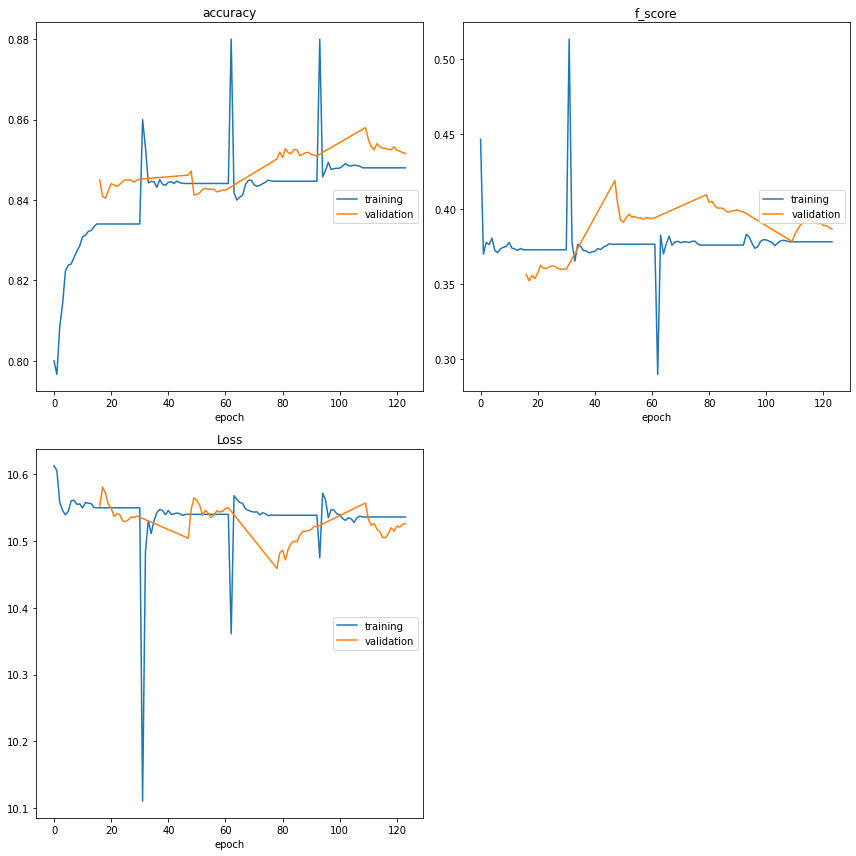

accuracy
	training         	 (min:    0.797, max:    0.880, cur:    0.848)
	validation       	 (min:    0.840, max:    0.858, cur:    0.852)
f_score
	training         	 (min:    0.290, max:    0.513, cur:    0.378)
	validation       	 (min:    0.352, max:    0.419, cur:    0.387)
Loss
	training         	 (min:   10.111, max:   10.613, cur:   10.536)
	validation       	 (min:   10.459, max:   10.581, cur:   10.526)


In [21]:
from torch import optim 

learning_rate = 0.003

optimizer = optim.Adam(list(gmu.ht_gate.parameters()) + list(gmu.z_gate.parameters()) + list(gmu.hv_gate.parameters()), lr=learning_rate)

criterion = nn.BCEWithLogitsLoss(reduction = 'none')
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps) 


# train_gmu(gmu, criterion, optimizer, scheduler, num_epochs)
train_gmu(gmu, optimizer, criterion, 4)